In [3]:
from tesspy import Tessellation, tessellation_functions
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from shapely import intersects
import mercantile
import matplotlib.pyplot as plt
import numpy as np
from libpysal import weights
import networkx as nx

## Read shapefiles

In [4]:
gdf_all = gpd.read_file("files/departments/all_deps.shp")
gdf_all.crs = "epsg:4326"

gdf_periurban = gpd.read_file("files/periurban/periurban.shp")
gdf_periurban.crs = "epsg:4326"

gdf_urban = gpd.read_file("files/urban/urban.shp")
gdf_urban.crs = "epsg:4326"

## Set parameters

In [5]:
LARGE_ZOOM_LEVEL = 13
MEDIUM_ZOOM_LEVEL = 14
SMALL_ZOOM_LEVEL = 15

In [6]:
SPLIT_THRESHOLD = 0.5

## Make reference grid

In [7]:
deps = Tessellation(gdf_all)
deps_large = tessellation_functions.get_squares_polyfill(deps.area_gdf, LARGE_ZOOM_LEVEL)
deps_large['index_copy'] = deps_large.index

In [8]:
def split_tile_to_zoom(tile_row, zoom_level):
  rows = []
  bbox = tile_row.geometry.bounds
  medium_tiles = mercantile.tiles(bbox[0], bbox[1], bbox[2], bbox[3], zoom_level)
  for tile in medium_tiles:
    square = box(*mercantile.bounds(tile))
    rows.append(square)
  return rows

def get_tiles_for_level(base_tiles_df, zoom_level):
  new_rows = []
  for row in base_tiles_df.apply(lambda row: split_tile_to_zoom(row, zoom_level), axis=1):
    new_rows.extend(row)
  new_df = pd.DataFrame(new_rows, columns=['geometry'])
  return gpd.GeoDataFrame(new_df, geometry='geometry', crs='epsg:4326')


## Periurban level

In [9]:
def intersects_filter(row):
  return intersects(row['geometry'], gdf_periurban['geometry'])

In [10]:
gdf_joined = gpd.overlay(gdf_periurban, deps_large, how = 'intersection')
large_tiles_periurban = deps_large[deps_large.apply(intersects_filter, axis=1)[0]]
gdf_joined.set_index('index_copy', inplace=True)
large_tiles_periurban['periurban_area_proportion'] = gdf_joined.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
large_tiles_periurban_filtered = large_tiles_periurban[large_tiles_periurban['periurban_area_proportion'] >= SPLIT_THRESHOLD]

/tmp/ipykernel_761180/4020474055.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  large_tiles_periurban['periurban_area_proportion'] = gdf_joined.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
medium_tiles = get_tiles_for_level(large_tiles_periurban_filtered, MEDIUM_ZOOM_LEVEL)

## Urban level

In [12]:
def urban_intersects_filter(row):
  return intersects(row['geometry'], gdf_urban['geometry'])
large_tiles_urban = deps_large[deps_large.apply(urban_intersects_filter, axis=1)[0]]

In [13]:
gdf_joined_urban = gpd.overlay(gdf_urban, deps_large, how = 'intersection')
gdf_joined_urban.set_index('index_copy', inplace=True)
large_tiles_urban['urban_area_proportion'] = gdf_joined_urban.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
large_tiles_urban_filtered = large_tiles_urban[large_tiles_urban['urban_area_proportion'] >= SPLIT_THRESHOLD]

/tmp/ipykernel_761180/3801076930.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  large_tiles_urban['urban_area_proportion'] = gdf_joined_urban.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
small_tiles = get_tiles_for_level(large_tiles_urban_filtered, SMALL_ZOOM_LEVEL)

## Compiling all tiles

In [15]:
tiles_df = deps_large[['geometry']].copy()
in_medium = tiles_df.index.isin(large_tiles_periurban_filtered.index)
tiles_df = tiles_df[~in_medium]
in_small = tiles_df.index.isin(large_tiles_urban_filtered.index)
tiles_df = tiles_df[~in_small]
tiles_df = pd.concat([tiles_df, small_tiles, medium_tiles])

## Measurements

## As network

/tmp/ipykernel_761180/930057799.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((tiles_df.centroid.x, tiles_df.centroid.y))
/tmp/ipykernel_761180/930057799.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(tiles_df)


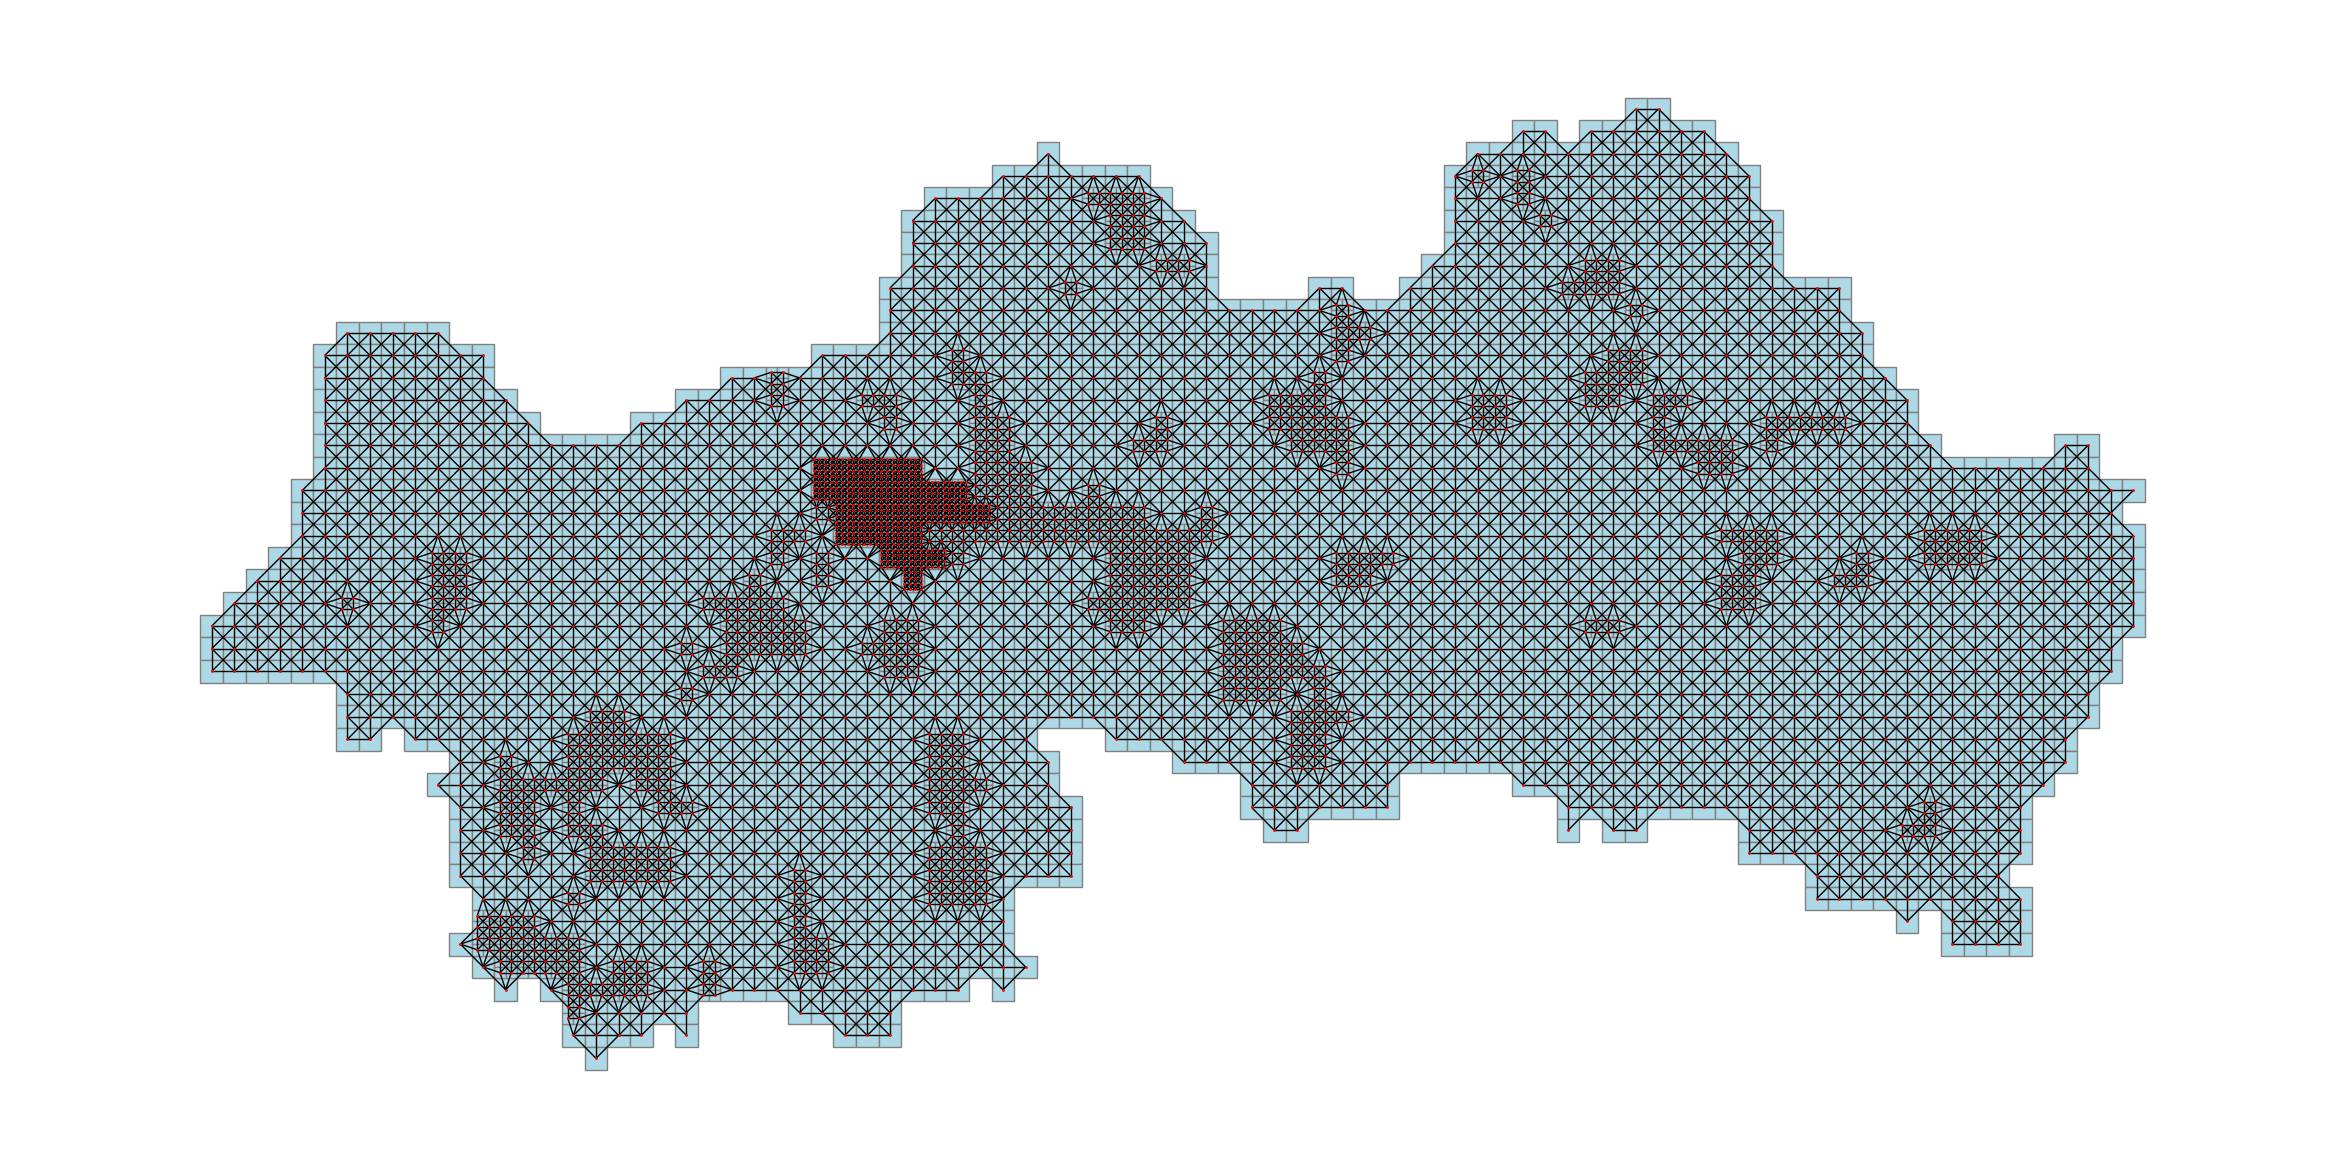

In [16]:
centroids = np.column_stack((tiles_df.centroid.x, tiles_df.centroid.y))
queen = weights.Queen.from_dataframe(tiles_df)
graph = queen.to_networkx()
positions = dict(zip(graph.nodes, centroids))
# plot with a nice basemap
ax = tiles_df.plot(linewidth=1, edgecolor="grey", figsize=(30, 30), facecolor="lightblue")
nx.draw(graph, positions, ax=ax, node_size=1, node_color="r")
plt.show()